In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
import os
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torchvision.utils import save_image

from PIL import Image

print(torch.__version__)
print(torch.cuda.is_available())

1.6.0
True


In [2]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    Tensor = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    Tensor = torch.FloatTensor
    
print('using device', device)

using device cuda


# Data ...

torch.Size([1, 3, 171, 256])


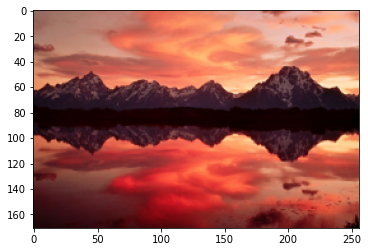

In [3]:
img_dir = 'data/'
# img_name = '33039_LR'
# img_name = 'balloons'
# img_name = 'birds'
# img_name = 'colusseum'
# img_name = 'cows'
# img_name = 'lightning1'
# img_name = 'mountains'
img_name = 'mountains3'


def image_open(image_dir, norm = True):
    x = Image.open(image_dir).convert('RGB')
    x = transforms.ToTensor()(x)
    
    if norm == True:
        x = x[np.newaxis, :]
        x = (x-0.5)*2
        x = x.clamp(-1,1)
    return x
    
x = image_open(img_dir+img_name+'.png')
print(x.shape)
plt.imshow((x[0].permute(1,2,0)+1)/2)
plt.show()

# Model

## generator

In [4]:
class Generator(nn.Module):
    def __init__(self, img_size, num_filter=32):
        super(Generator, self).__init__()

        self.num_filter = num_filter
        
        # model
        self.model = nn.ModuleList()
        
        self.model.append(nn.Sequential(nn.Conv2d(3, self.num_filter, 3, 1,1),
                                        nn.LeakyReLU(2e-1)))
        for _ in range(3):
            self.model.append(nn.Sequential(nn.Conv2d(self.num_filter, self.num_filter, 3, 1,1),
                                            nn.BatchNorm2d(self.num_filter),
                                            nn.LeakyReLU(2e-1)))

        self.model.append(nn.Sequential(nn.Conv2d(self.num_filter, 3, 3, 1,1),
                                        nn.Tanh()))
        self.model = nn.Sequential(*self.model)
        
    def change_required_grad(self, required_grad=True):
        for param in self.model.parameters():
            param.requires_grad = required_grad
    
    def forward(self, z, prev_upsampled_img=None):
        if prev_upsampled_img == None:
            return self.model(z)
        else:
            assert z.shape == prev_upsampled_img.shape, 'z and image size is no same, z:{}  , img:{}'.format(z.shape, img.shape)
            x = self.model(z+prev_upsampled_img) + prev_upsampled_img
            return x

## Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self,num_filter=32):
        super(Discriminator, self).__init__()
        self.num_filter = num_filter
        
        # model
        self.model = nn.ModuleList()
        self.model.append(nn.Sequential(nn.Conv2d(3, self.num_filter, 3, 1, 1),
                                        nn.LeakyReLU(2e-1)))
        for _ in range(3):
            self.model.append(nn.Sequential(nn.Conv2d(self.num_filter, self.num_filter, 3, 1, 1),
                                            nn.BatchNorm2d(self.num_filter),
                                            nn.LeakyReLU(2e-1)))
        self.model.append(nn.Sequential(nn.Conv2d(self.num_filter, 1, 3, 1, 1)))
        
        self.model = nn.Sequential(*self.model)
    
    def change_required_grad(self, required_grad=True):
        for param in self.model.parameters():
            param.requires_grad = required_grad
    
    def forward(self, x):
        return self.model(x)

### Gradient penalty of WGAN

In [6]:
# ref : https://github.com/FriedRonaldo/SinGAN/
def compute_wgan_gp(D, x, x_hat,LAMBDA = 0.1):
    epsilon = torch.rand(x.size(0),1,1,1).to(device)
    
    x_inter = ( (1-epsilon)*x + epsilon*x_hat ).detach()
    x_inter.requires_grad = True
    
    d_inter = D(x_inter)
    grad = torch.autograd.grad(d_inter, x_inter,
                              grad_outputs=torch.ones_like(d_inter), create_graph=True)[0]
    norm = grad.view(grad.size(0), -1).norm(p=2, dim=1)
    d_gp = ((norm-1)**2).mean()*LAMBDA
    return d_gp

### image resize function

In [7]:
def resize_img(x, size):
    if x==None: return None
    return F.interpolate(x, size, mode='bilinear', align_corners=True)

## SinGAN

In [8]:
class SinGAN(nn.Module):
    def __init__(self, num_scale, scale_factor=4/3):
        super(SinGAN, self).__init__()
        
        self.num_scale = num_scale # N
        self.scale_factor = scale_factor
        
        self.img_min_size = 25
        
        self.num_filter = 32 # in paper
        self.current_level = -1

        self.g_iter = 3 #
        self.d_iter = 3 #
        self.img_name = 'None'
        
        self.scale_factors = [math.pow(self.scale_factor, num_scale -i) for i in range(1,num_scale+1)]
        
        self.z_rec_list = []
        self.rmse_list = []
        self.sub_Gs = []
        self.sub_Ds = []
        
    def train(self, x, epochs = 2):
        # x shape must be : [1, channel, W, H]
        size_list = []
        for scale_factor in self.scale_factors:
            size_list.append((max(self.img_min_size, math.floor(x.size(2)/scale_factor)),max(self.img_min_size, math.floor(x.size(3)/scale_factor))))
        
        print('size list :', size_list)
        x_list = [resize_img(x, img_size).to(device) for img_size in size_list]
        
        g_level_losses = {}
        d_level_losses = {}
        
        x_rec_prev = None
        for level in range(self.num_scale):
            self.progress()
            print('level {} train start'.format(level))
            
            # train mode & turn on required_grad
            self.sub_Gs[level].change_required_grad(True)
            self.sub_Gs[level].train()
            self.sub_Ds[level].change_required_grad(True)
            self.sub_Ds[level].train()
            
            # train
            g_losses, d_losses, x_rec_prev = self.level_step_train(level, x_list[level], x_rec_prev ,size_list, epochs)
            g_level_losses[level] = g_losses
            d_level_losses[level] = d_losses
            
            # eval mode & turn off required_grad
            self.sub_Gs[level].change_required_grad(False)
            self.sub_Gs[level].eval()
            self.sub_Ds[level].change_required_grad(False)
            self.sub_Ds[level].eval()
            
        print('Train Done')
        return g_level_losses, d_level_losses
        
    def level_step_train(self,level, x, x_rec_prev, size_list, epochs):
        
        G = self.sub_Gs[level]
        D = self.sub_Ds[level]
        
        #G.change_required_grad(True)
        #D.change_required_grad(True)
        
        # define optimizer
        g_opt = torch.optim.Adam(self.sub_Gs[level].parameters(), lr = 5e-4, betas = (0.5, 0.999))
        d_opt = torch.optim.Adam(self.sub_Ds[level].parameters(), lr = 5e-4, betas = (0.5, 0.999))
        g_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=g_opt,milestones=[1600],gamma=0.1)
        d_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=d_opt,milestones=[1600],gamma=0.1)
        
        # create z_rec and rmse then store.
        if level == 0:
            z_rec = torch.randn(x.shape).to(device)
            x_rec_prev_upsample = None
            rmse = 1.
        else:
            z_rec = torch.zeros_like(x).to(device)
            x_rec_prev_upsample = resize_img(x_rec_prev, (x.size(2),x.size(3))).to(device)
            rmse = torch.sqrt(F.mse_loss(x_rec_prev_upsample, x))
        self.z_rec_list.append(z_rec)
        self.rmse_list.append(rmse)
        
        g_losses = []
        d_losses = []        
        # epoch
        for epoch in range(epochs):
            
            # Update D : maximize D(x) + D(G(z))
            for d_epoch in range(self.d_iter):
                # D(x) : train with real
                d_opt.zero_grad()
                
                d_out_real = D(x).to(device)
                d_loss_real = -d_out_real.mean()
                d_loss_real.backward(retain_graph=True)
                
                # D(G(z)) : train with fake
                noise_list = [noise_amp*torch.randn(1,3,size[0],size[1]).to(device) for noise_amp,size in zip(self.rmse_list[:level+1], size_list[:level+1])]
                x_prev = self.forward_Gs(self.sub_Gs[:level], noise_list[:level])
                x_hat = G(noise_list[-1].detach(), resize_img(x_prev, (x.size(2),x.size(3)) ) )
                d_out_fake = D(x_hat.detach()).to(device)
                d_loss_fake = d_out_fake.mean()
                d_loss_fake.backward(retain_graph=True)
                
                # WGAN-gp : train gradient penalty of WGAN-GP
                d_gp = compute_wgan_gp(D,x,x_hat,LAMBDA=0.1)
                d_gp.backward()
                
                d_opt.step()
                
                # record loss
                d_losses.append(d_loss_real.item() + d_loss_fake.item() + d_gp.item())
                
            # g train : maximize D(G(z))
            for g_epoch in range(self.g_iter):
                g_opt.zero_grad()
                
                # D(G(z))
                noise_list = [noise_amp*torch.randn(1,3,size[0],size[1]).to(device) for noise_amp,size in zip(self.rmse_list[:level+1], size_list[:level+1])]
                x_prev = self.forward_Gs(self.sub_Gs[:level], noise_list[:level])
                x_hat = G(noise_list[-1].detach(), resize_img(x_prev, (x.size(2), x.size(3))))
                d_out_fake = D(x_hat)
                g_loss = -d_out_fake.mean()
                g_loss.backward(retain_graph=True)
                
                # reconstruction loss
                x_rec = G(noise_list[-1].detach(), x_rec_prev_upsample)
                rec_loss = F.mse_loss(x_rec, x)*10
                rec_loss.backward(retain_graph=True)
                
                g_opt.step()
                # record loss
                g_losses.append(g_loss.item() + rec_loss.item())
            
            g_scheduler.step()
            d_scheduler.step()
            
            # verbose
            if epoch % 25 == 0 or epoch==(epochs-1):
                print('level {} {:4}/{:4}'.format(level, epoch, epochs), end=', ')
            
            # checkpoint save
            if epoch % 100 == 0 or epoch == (epochs-1):
                print()
                save_path = 'result/{}/{}'.format(self.img_name, level)
                os.makedirs(save_path, exist_ok=True)
                save_image(x_hat, save_path+'/x_hat.png')
                torch.save(G.state_dict(), save_path+'/G.pth')
                
        new_x_rec_prev = G(noise_list[-1].detach(), x_rec_prev_upsample)
        
        # save current level network.
        torch.save(G, save_path+'/G.pth')
        torch.save(D, save_path+'/D.pth')
        save_image(new_x_rec_prev, save_path+'/x_rec.png')
        
        return g_losses, d_losses, new_x_rec_prev
    
    def forward_Gs(self, sub_Gs, z_list):
        if (not sub_Gs) or (not z_list):
            return None
        # first layer
        x = sub_Gs[0](z_list[0])
        
        for G, z in zip(sub_Gs[1:], z_list[1:]):
            x = resize_img(x, (z.size(2),z.size(3)) )
            x = G(z,x)
        return x
    
    def progress(self):
        self.current_level +=1
        
        if self.current_level%4 == 0:
            self.num_filter *= 2
        
        num_filter = self.num_filter
        
        new_G = Generator(num_filter).to(device)
        new_D = Discriminator(num_filter).to(device)
                
        # Initialize layers via copy
        if self.current_level%4 != 0:
            new_G.load_state_dict(self.sub_Gs[-1].state_dict())
            new_D.load_state_dict(self.sub_Ds[-1].state_dict())
        
        self.sub_Gs.append(new_G)
        self.sub_Ds.append(new_D)
        print('progress done')

In [ ]:
# load image
x = image_open(img_dir+'/'+img_name+'.png')
print(img_name, "Data Load")
print('Image shape : ', x.shape)

# create SinGAN
singan = SinGAN(num_scale = 8)
singan.img_name = img_name

losses = singan.train(x, epochs = 2000)

save_path = 'result/{}'.format(img_name)
os.makedirs(save_path, exist_ok = True)

torch.save(singan, save_path+'/singan.pth')
torch.save(losses, save_path+'/losses.dict')

mountains3 Data Load
Image shape :  torch.Size([1, 3, 171, 256])
size list : [(25, 34), (30, 45), (40, 60), (54, 81), (72, 108), (96, 144), (128, 192), (171, 256)]
progress done
level 0 train start
level 0    0/2000, 
level 0   25/2000, level 0   50/2000, level 0   75/2000, level 0  100/2000, 
level 0  125/2000, level 0  150/2000, level 0  175/2000, level 0  200/2000, 
level 0  225/2000, level 0  250/2000, level 0  275/2000, level 0  300/2000, 
level 0  325/2000, level 0  350/2000, level 0  375/2000, level 0  400/2000, 
level 0  425/2000, level 0  450/2000, level 0  475/2000, level 0  500/2000, 
level 0  525/2000, level 0  550/2000, level 0  575/2000, level 0  600/2000, 
level 0  625/2000, level 0  650/2000, level 0  675/2000, level 0  700/2000, 
level 0  725/2000, level 0  750/2000, level 0  775/2000, level 0  800/2000, 
level 0  825/2000, level 0  850/2000, level 0  875/2000, level 0  900/2000, 
level 0  925/2000, level 0  950/2000, level 0  975/2000, level 0 1000/2000, 
level 0 1025

level 5   25/2000, level 5   50/2000, level 5   75/2000, level 5  100/2000, 
level 5  125/2000, level 5  150/2000, level 5  175/2000, level 5  200/2000, 
level 5  225/2000, level 5  250/2000, level 5  275/2000, level 5  300/2000, 
level 5  325/2000, level 5  350/2000, level 5  375/2000, level 5  400/2000, 
level 5  425/2000, level 5  450/2000, level 5  475/2000, level 5  500/2000, 
level 5  525/2000, level 5  550/2000, level 5  575/2000, level 5  600/2000, 
level 5  625/2000, level 5  650/2000, level 5  675/2000, level 5  700/2000, 
level 5  725/2000, level 5  750/2000, level 5  775/2000, level 5  800/2000, 
level 5  825/2000, level 5  850/2000, level 5  875/2000, level 5  900/2000, 
level 5  925/2000, level 5  950/2000, level 5  975/2000, level 5 1000/2000, 
level 5 1025/2000, level 5 1050/2000, level 5 1075/2000, level 5 1100/2000, 
level 5 1125/2000, level 5 1150/2000, level 5 1175/2000, level 5 1200/2000, 
level 5 1225/2000, level 5 1250/2000, level 5 1275/2000, level 5 1300/2000, 